### Energy consumption
Martien Lubberink


### This script downloads energy consumption data from the IEA, then shows graphs for various types of energy resources, e.g. renewables, non-renewables.

In [0]:
"""
Created on Sat Apr 24 12:07:21 2021
@author: martien lubberink
https://www.iea.org/reports/monthly-electricity-statistics
"""

In [6]:
#  The usual shots across the bow.

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#  Helper defs

def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)

def fun(s):
    s = re.sub('[+-=]', '', s)
    return s

The cell below downloads Monthly OECD electricity statistics data from the IEA, then reads data from the  New Detailed Breakdown sheet into memory. 

Unfortunately, all the data is in one sheet and poorly structured. I solve this by identifying the various data ranges in the sheet. 

The frame `dfi` then identifies the data ranges for each country. 

In [8]:
def get_ranges(df):
    i = list(df[df['1 estimated'] == 'GWh'].index)
    idx = [x+1 for x in i]
    jdx = [x-1 for x in i][1:]
    jdx.append(df.index.max())
    z = list(zip(df['1 estimated'].loc[idx].to_list(), idx, jdx))
    df = pd.DataFrame.from_dict(z)
    df.columns = ['country', 'start', 'end']
    return df.set_index('country')

# Here is the source of the data:
fn = 'https://iea.blob.core.windows.net/assets/25a3e8b2-efd6-4f0f-ab9c-dafc7bd505be/Archive_Table_Revised.xlsx'
# If the line above does not work, try this instead:
# fn = 'Archive_Table_Revised.xlsx'

# Bundle all sheets of the xlsx file into a dictionary:
sheets_dict = pd.read_excel(fn, sheet_name=None)

# This is the sheet we need
dfs = sheets_dict['New Detailed Breakdown'].iloc[2:]

# This frame has an index of the data ranges:
dfi = get_ranges(dfs)

If this site complains about xlrd, the run hte folloing command:

In [5]:
#!pip install openpyxl

In [4]:
# Show some data
dfs.head(3)

,1 estimated,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237
2,GWh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUSTRALIA,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CONVENTIONAL THERMAL,18689.116,20098.456,19359.122,18765.667,17544.744,18988.211,17987.95,17090.675,15936.137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The cell below shapes the data for a country into a neat dataframe. It uses the index frame to determine where the data resides.

I chose Germany.

In [6]:
def get_country(dfi, dfs, country):
    row  = dfi.loc[country]
    df = dfs.loc[row.start: row.end]
    df = df.copy()
    [df.dropna(axis = x, inplace=True, how = 'all') for x in [0, 1]]
    df.columns = df.iloc[0]
    df.rename(columns = {country: 'item'}, inplace=True)
    df['item'] = df['item'].apply(fun).str.strip()
    df = df[df['item'] != country]
    df.set_index(['item'], inplace=True)
    df = df.apply(pd.to_numeric,  errors='coerce')
    df = df.T
    df.columns = df.columns.str.lower()
    df.columns = [re.sub(' ',"_", x) for x in df]
    df.index.names=['date']
    df['month'] = df.index
    df['month'] = df['month'].dt.month
    return(df)

df = get_country(dfi, dfs, 'GERMANY')

In [7]:
#  Show some data
df.head(2)

,conventional_thermal,coal,oil,natural_gas,combustible_renewables,other_combustibles,nuclear,hydro,wind,solar,...,renewables,nonrenewables,total_net_production,imports,exports,electricity_supplied,used_for_pumped_storage,t&d_losses,electricity_consumed,month
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,37520.951,23861.778,689.403,8297.275,4110.732,561.763,7797.872,2065.130,9772.898,702.139,...,16661.849,41343.036,58004.885,2599.089,8950.243,51653.731,743.059,2601.065,48309.607,1
2016-02-01 00:00:00,32023.101,20606.282,595.462,6431.356,3853.061,536.940,7203.726,2317.373,10379.970,1349.734,...,17911.198,35545.271,53456.469,2606.367,7497.407,48565.429,612.332,2320.073,45633.024,2


In [8]:
#  Show some data
df.tail(2)

,conventional_thermal,coal,oil,natural_gas,combustible_renewables,other_combustibles,nuclear,hydro,wind,solar,...,renewables,nonrenewables,total_net_production,imports,exports,electricity_supplied,used_for_pumped_storage,t&d_losses,electricity_consumed,month
date,,,,,,,,,,,,,,,,,,,,,
2020-12-01 00:00:00,29104.484,15222.546,321.182,8868.040,4240.827,451.889,5842.459,1802.689,11653.773,778.108,...,18489.898,30870.239,49360.137,3813.794,7208.908,45965.023,753.810,2726.007,42485.206,12
2021-01-01 00:00:00,31700.365,17415.366,324.934,9323.411,4174.834,461.820,5925.921,1800.370,11538.260,692.341,...,18221.832,33595.614,51817.446,3880.863,7399.497,48298.812,712.795,2712.970,44873.047,1


Now make some nice graphs. I chose to show the energy use per calendar month.

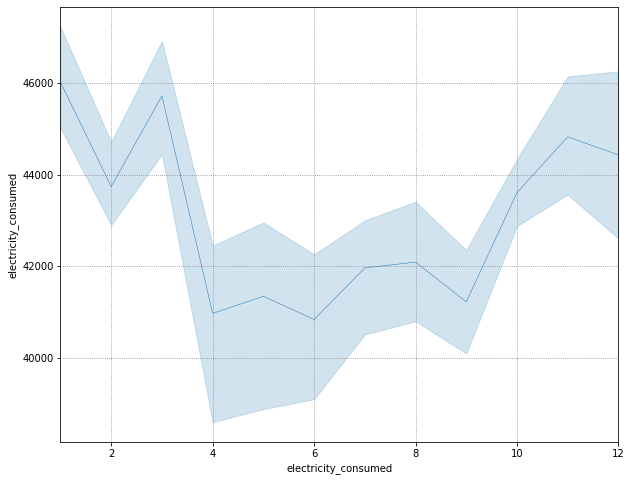

In [9]:
def graphs(df, lyst):
    for i in lyst:
        if i in list(df):
            if i!='month':
                fig = plt.figure(figsize=(10,8))
                fig.tight_layout()
                ax = fig.add_subplot(111)
                ax = sns.lineplot(x="month", y=i, linewidth = 0.5, data=df)
                ax.set_xlabel(i)
                plt.grid(linestyle="dotted", color='grey')
                set_xmargin(ax, left=0, right=0)
                plt.plot()

graphs(df, ['conventional_thermal', 'nuclear', 'hydro', 'wind', 'solar', 'geothermal', 'renewables', 'nonrenewables', 'total_net_production', 'electricity_consumed'])